# MNIST Anomaly Detection

Baseline from: https://arxiv.org/pdf/2006.02516.pdf

- 14x14, [$0-1$] range, pixels flattened (dont exploit inherent locality)
- Embedding = trigonometric (p=2)
- Combined loss: $\mathcal{L} = \frac{1}{N}\sum_{i=1}^{N} \left( \log \left\| P \Phi({X_i}) \right\|_2^2 - 1 \right)^2 + \alpha \cdot \mathrm{ReLU}\left(\log(\|P\|_F^2)\right)$

**Imports**

In [1]:
import jax.numpy as jnp
import quimb.tensor as qtn
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from jax.nn.initializers import *
from flax.training.early_stopping import EarlyStopping
import matplotlib.pyplot as plt

from tn4ml.initializers import *
from tn4ml.models.smpo import *
from tn4ml.models.model import *
from tn4ml.embeddings import *
from tn4ml.metrics import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
jax.config.update("jax_enable_x64", True)

**Load dataset**

In [3]:
train, test = mnist.load_data()
data = {"X": dict(train=train[0], test=test[0]), "y": dict(train=train[1], test=test[1])}

In [4]:
normal_class = 0

In [5]:
# training data
X = {
"normal": data["X"]["train"][data["y"]["train"] == normal_class]/255.0,
"anomaly": data["X"]["train"][data["y"]["train"] != normal_class]/255.0,
}

In [6]:
# test data
X_test = {
"normal": data["X"]["test"][data["y"]["test"] == normal_class]/255.0,
"anomaly": data["X"]["test"][data["y"]["test"] != normal_class]/255.0,
}

In [7]:
# Function to resize images to 14x14
def resize_images(images):
    resized_images = tf.image.resize(images, [14, 14], method=tf.image.ResizeMethod.AREA)
    return resized_images.numpy()

In [8]:
X_resized = {
    "normal": resize_images(np.expand_dims(X["normal"], axis=-1)),
    "anomaly": resize_images(np.expand_dims(X["anomaly"], axis=-1)),
}

X_test_resized = {
    "normal": resize_images(np.expand_dims(X_test["normal"], axis=-1)),
    "anomaly": resize_images(np.expand_dims(X_test["anomaly"], axis=-1)),
}

In [9]:
X_resized['normal'].shape

(5923, 14, 14, 1)

### Rearrange pixels in zig-zag order
- (from https://arxiv.org/pdf/1605.05775.pdf)

<img src="images/zig-zag.png" alt="MPS Params" width="150" height="150">

In [10]:
def zigzag_order(data):
    data = np.squeeze(data)
    data_zigzag = []
    for x in data:
        image = []
        for i in x:
            image.extend(i)
        data_zigzag.append(image)
    return np.asarray(data_zigzag)

In [11]:
zigzag = True

In [12]:
if zigzag:
    train_normal = zigzag_order(X_resized["normal"])
    test_normal = zigzag_order(X_test_resized["normal"])

    train_anomaly = zigzag_order(X_resized["anomaly"])
    test_anomaly = zigzag_order(X_test_resized["anomaly"])
else:
    train_normal = X_resized['normal'].reshape(-1, X_resized['normal'].shape[1]*X_resized['normal'].shape[2])
    test_normal = X_test_resized['normal'].reshape(-1, X_test_resized['normal'].shape[1]*X_test_resized['normal'].shape[2])

    train_anomaly = X_resized['anomaly'].reshape(-1, X_resized['anomaly'].shape[1]*X_resized['anomaly'].shape[2])
    test_anomaly = X_test_resized['anomaly'].reshape(-1, X_test_resized['anomaly'].shape[1]*X_test_resized['anomaly'].shape[2])

In [13]:
# take train_size samples from normal class for training
train_size = 2048

indices = list(range(len(train_normal)))
np.random.shuffle(indices)

indices = indices[:train_size]
train_normal = np.take(train_normal, indices, axis=0)

**Training setup** &nbsp;
- direct gradient descent

In [14]:
# define model parameters
L = 14*14
initializer = gramschmidt('normal', 1e-2)
key = jax.random.key(42)
shape_method = 'noteven'
bond_dim = 10
phys_dim = (2,2)
spacing = 8
add_identity = False
boundary='obc'

In [15]:
model = SMPO_initialize(L=L,
                        initializer=initializer,
                        key=key,
                        shape_method=shape_method,
                        spacing=spacing,
                        bond_dim=bond_dim,
                        phys_dim=phys_dim,
                        cyclic=False,
                        compress=True,
                        add_identity=add_identity,
                        boundary=boundary)

In [16]:
# # Exponential decay of the learning rate.
# scheduler = optax.exponential_decay(
#     init_value=1e-5,
#     transition_steps=1000,
#     decay_rate=0.01)

# # Combining gradient transforms using `optax.chain`.
# gradient_transforms = [
#     optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
#     optax.scale_by_adam(),  # Use the updates from adam.
#     optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
#     # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
#     optax.scale(-1.0)
# ]

In [17]:
alpha = 0.4
def loss_combined(*args, **kwargs):
    error = LogQuadNorm
    reg = LogReLUFrobNorm
    return CombinedLoss(*args, **kwargs, error=error, reg=lambda P: alpha*reg(P))

In [18]:
# define training parameters
epochs = 100
batch_size = 128
optimizer = optax.adam
strategy = 'global'
loss = loss_combined
train_type = 0
embedding = trigonometric()
learning_rate = 1e-4
earlystop = EarlyStopping(min_delta=0, patience=5)

model.configure(optimizer=optimizer, strategy=strategy, loss=loss, train_type=train_type, learning_rate=learning_rate)

In [19]:
history = model.train(train_normal,
            epochs=epochs,
            batch_size=batch_size,
            embedding = embedding,
            normalize=True,
            earlystop=earlystop,
            cache=True, # compiling loss function to use it multiple times
            dtype=jnp.float64)

epoch:  62%|██████▏   | 62/100 [03:42<02:16,  3.59s/it, loss=3801.8950595377146]

Met early stopping criteria on training data, breaking at epoch 62


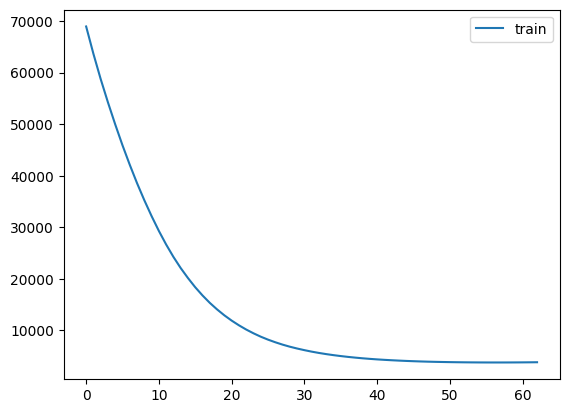

In [20]:
# plot loss
plt.plot(range(len(model.history['loss'])), model.history['loss'], label='train')
plt.legend()
plt.show()

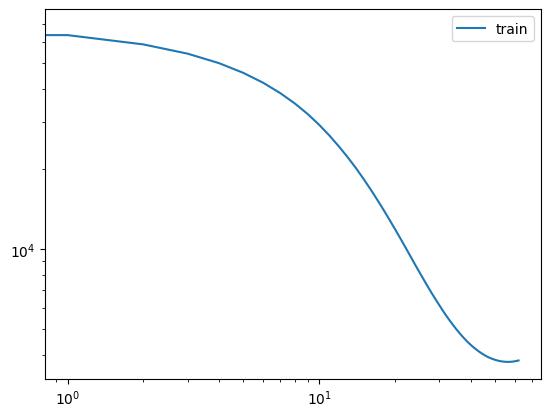

In [21]:
plt.loglog(range(len(model.history['loss'])), model.history['loss'], label='train')
plt.legend()
plt.show()

**Evaluate**

In [22]:
from sklearn.metrics import roc_curve, auc

In [23]:
indices = list(range(len(test_anomaly)))
np.random.shuffle(indices)

indices = indices[:len(test_normal)]
test_anomaly = np.take(test_anomaly, indices, axis=0)

In [24]:
loss = LogQuadNorm

anomaly_score = model.evaluate(test_anomaly, evaluate_type=0, return_list=True, dtype=jnp.float64, batch_size=128, embedding=embedding, metric = loss)
normal_score = model.evaluate(test_normal, evaluate_type=0, return_list=True, dtype=jnp.float64, batch_size=128, embedding=embedding, metric = loss)

**Plot anomaly scores and ROC curve**

In [25]:
def get_roc_data(normal, anomaly):
    true_val = np.concatenate((np.ones(anomaly.shape[0]), np.zeros(normal.shape[0])))
    pred_val = np.concatenate((anomaly, normal))
    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)
    return fpr_loss, tpr_loss

In [26]:
fpr, tpr = get_roc_data(normal_score, anomaly_score)
auc_value = auc(fpr, tpr)

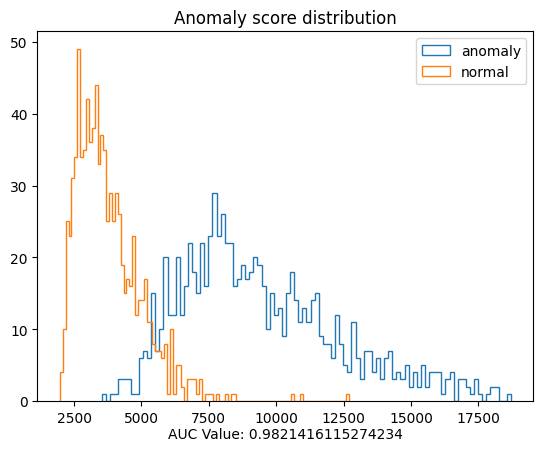

In [27]:
plt.figure()
plt.hist(anomaly_score, bins=100, histtype='step', label='anomaly')
plt.hist(normal_score, bins=100, histtype='step', label='normal')
plt.title('Anomaly score distribution')
plt.legend()
plt.text(0.5, -0.1, f'AUC Value: {auc_value}', ha='center', transform=plt.gca().transAxes)
plt.legend()
plt.show()

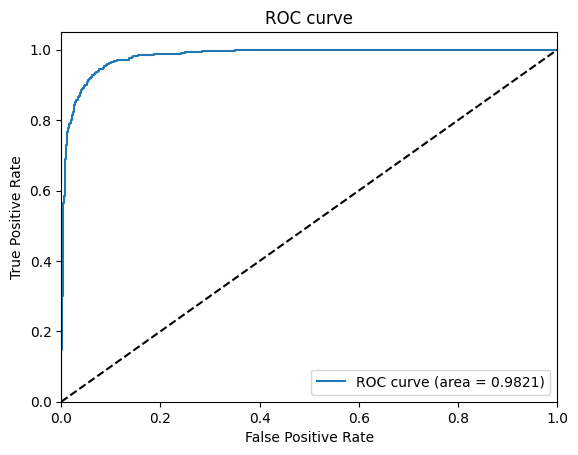

In [28]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc_value)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()
